# Pitchers on stance for ALL teams in postseason

In [1]:
import pandas as pd
import numpy as np
import duckdb
from duckdb.typing import *

pbp_df = pd.read_csv('../cleaned/pitch_by_pitch.csv')
games_df = pd.read_csv('../cleaned/games.csv')
pitchers_df = pd.read_csv('../cleaned/pitchers.csv')
con = duckdb.connect()

/var/folders/y6/bsdqshxs0s7_lwn4r5z7wtwc0000gn/T/ipykernel_28336/3362021003.py:4: DeprecationWarning: `duckdb.typing` is deprecated and will be removed in a future version. Please use `duckdb.sqltypes` instead.
  from duckdb.typing import *


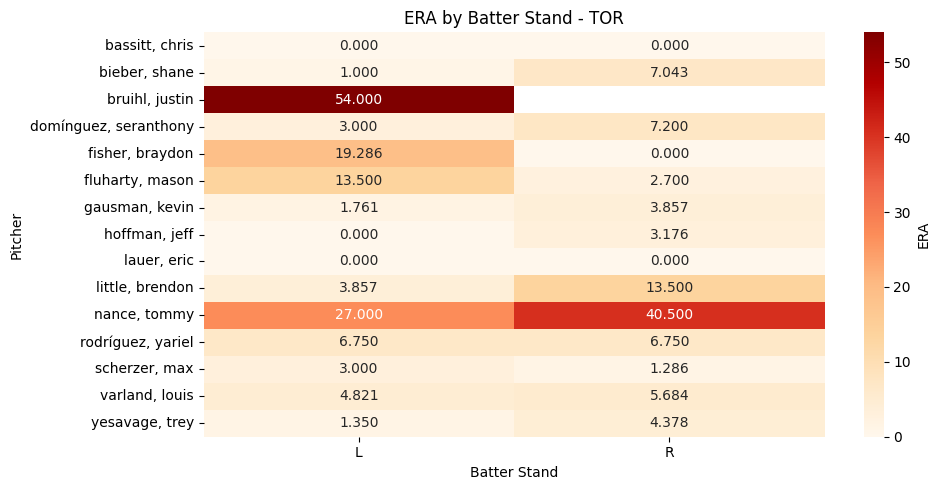

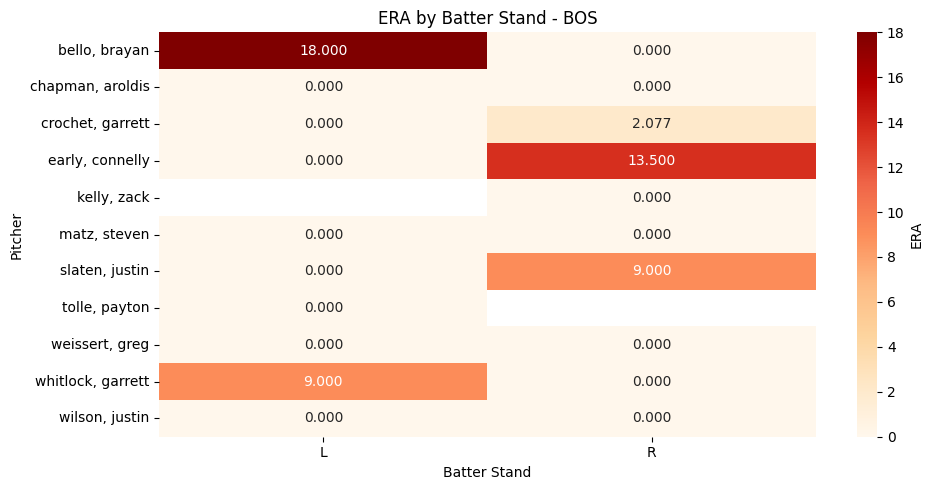

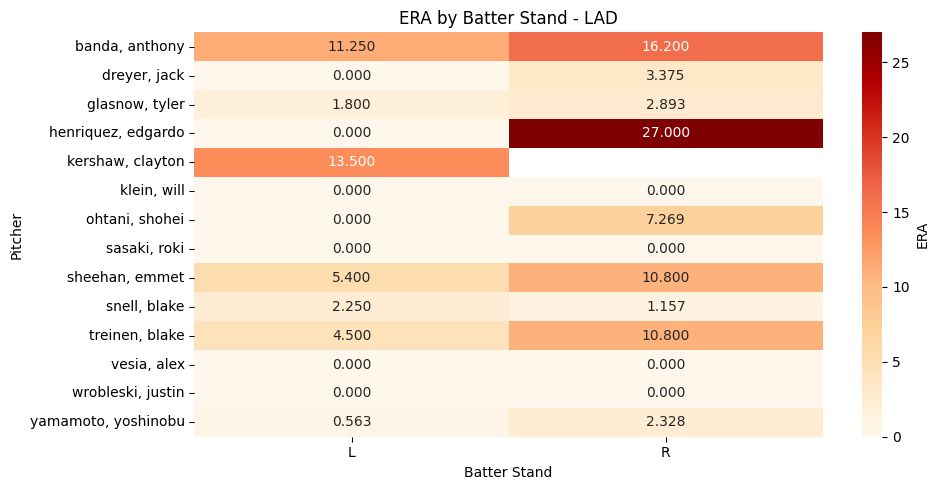

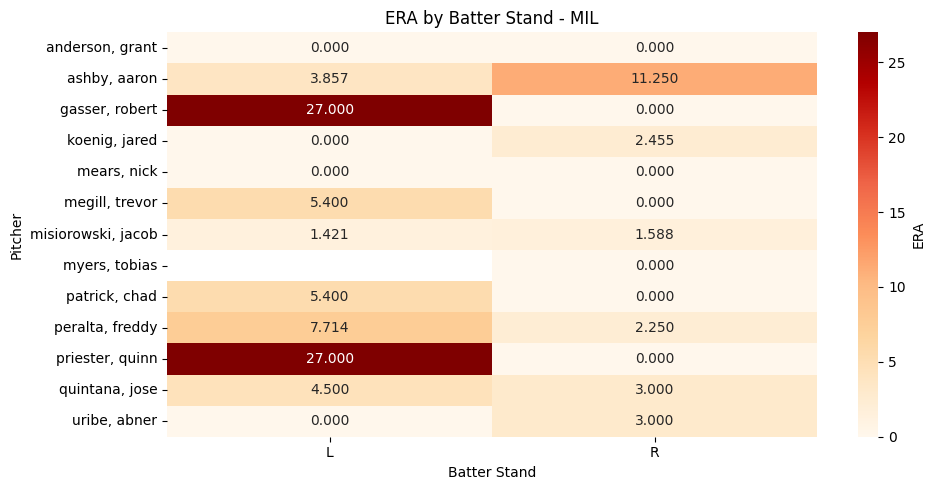

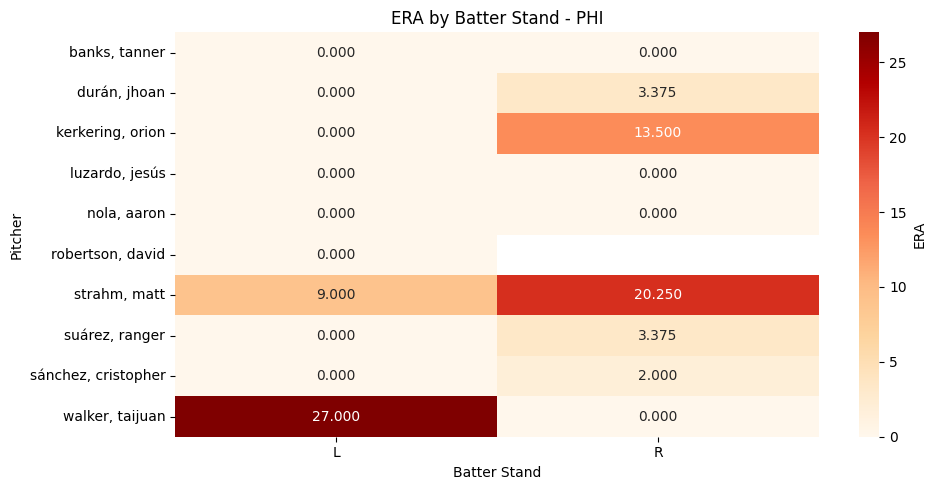

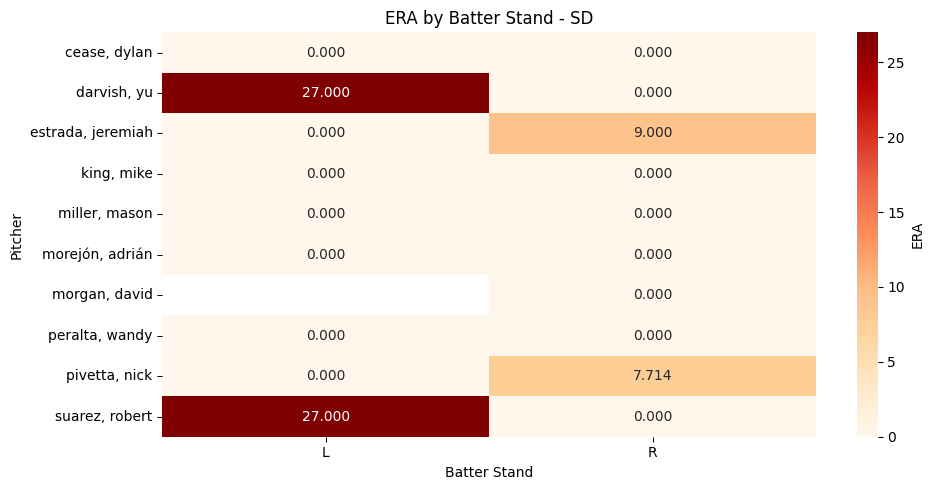

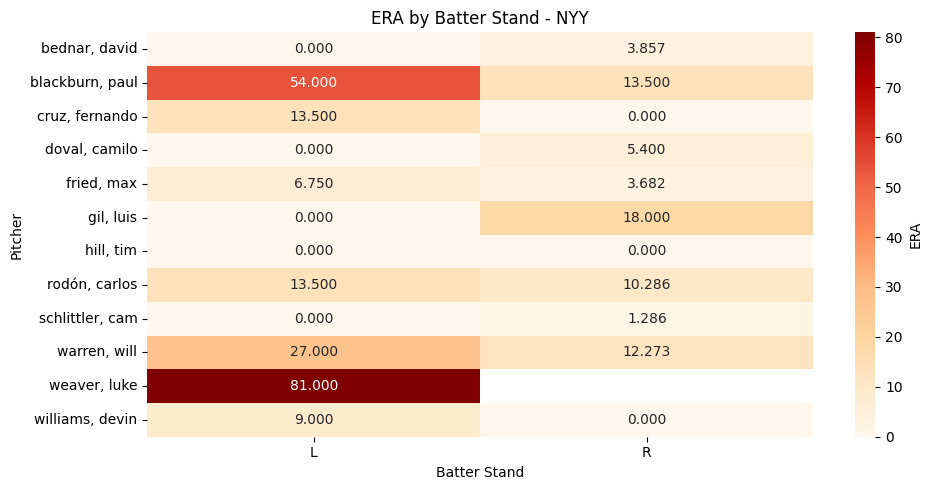

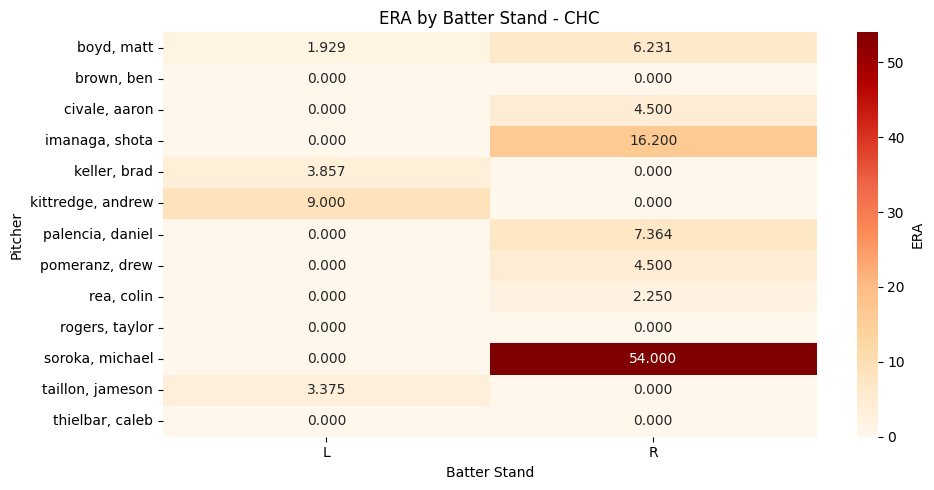

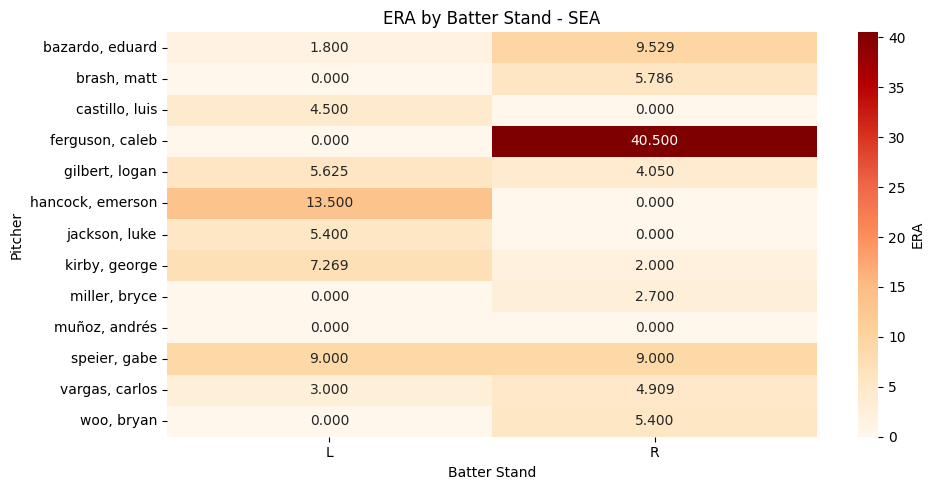

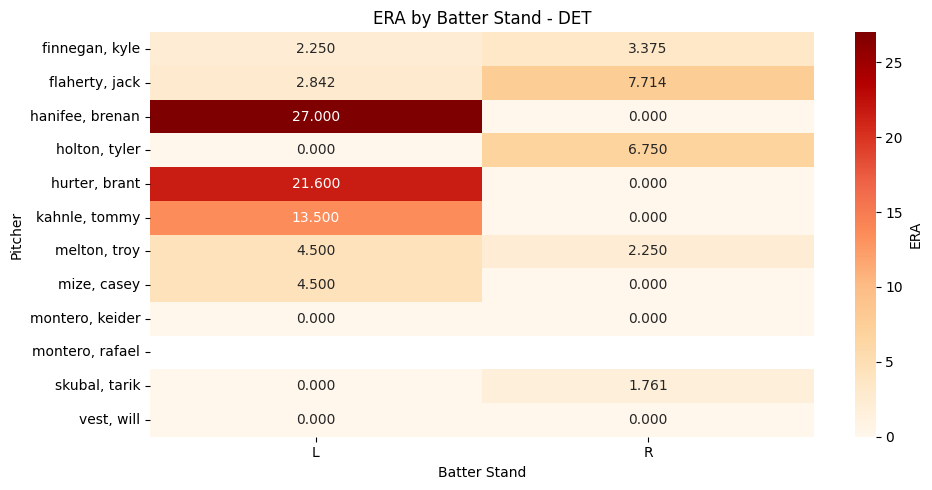

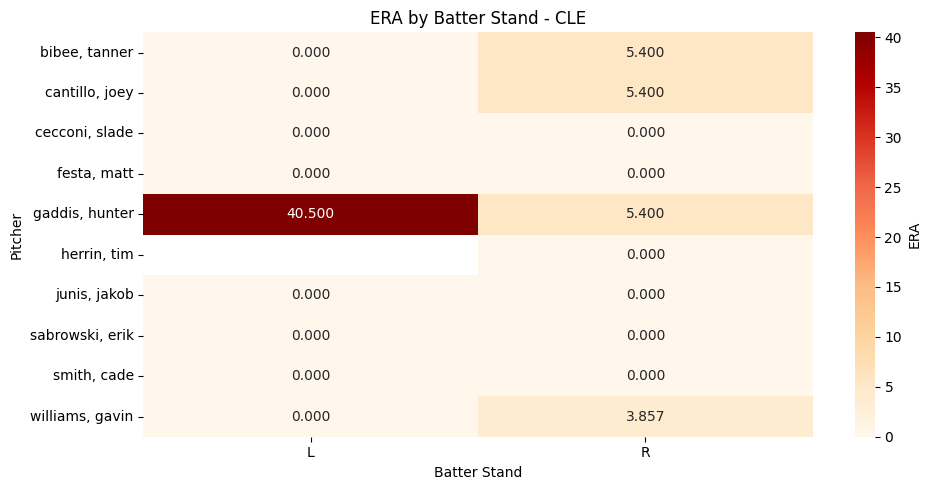

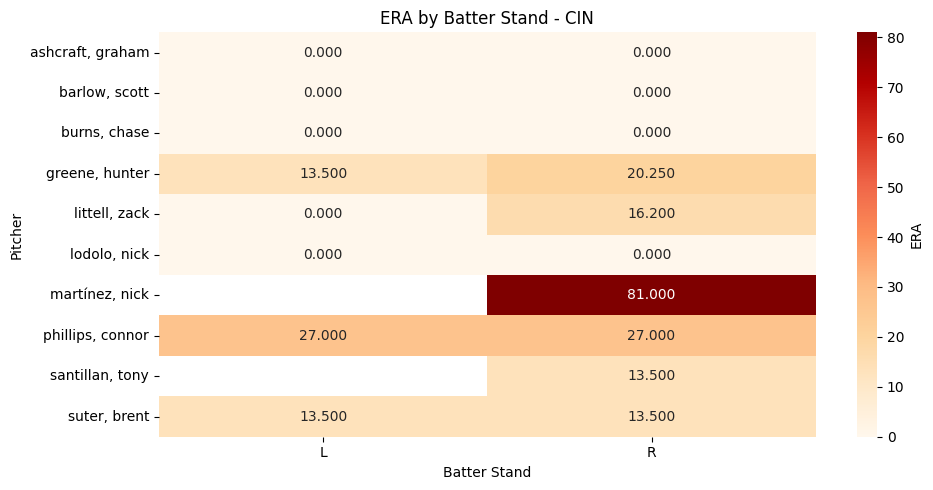

In [2]:
# pitcher performance on each handed batters
# along with batter performance on what handed pitcher
import matplotlib.pyplot as plt
import seaborn as sns

# output variables
    # ERA on each sided batter
era_by_stand = con.sql("""
WITH pitcher_stats AS (
    SELECT stand, pitcher,
        SUM(CASE 
                WHEN events IN ('strikeout','field_out','force_out','grounded_into_double_play','strikeout_double_play') 
                THEN 1 
                ELSE 0 
            END) as outs,
        SUM(CASE 
                WHEN events IN ('home_run','single','double','triple','walk','hit_by_pitch')
                     AND post_bat_score > bat_score
                THEN post_bat_score - bat_score
                ELSE 0
            END) as earned_runs
    FROM pbp_df
    GROUP BY stand, pitcher
) SELECT stand, pitcher, outs / 3.0 AS innings_pitched, earned_runs,
    CASE 
        WHEN outs = 0 THEN null
        ELSE round((earned_runs * 9.0) / (outs / 3.0), 3)
    END AS ERA
FROM pitcher_stats
ORDER BY pitcher, ERA DESC;
""").to_df()

pitcher_era_data = era_by_stand.merge(pitchers_df, left_on = 'pitcher', right_on = 'pitcher_id', how = 'left').drop(columns = ['pitcher_id'])

teams = pitcher_era_data['team_name'].unique()

for team in teams:
    df_team = pitcher_era_data[pitcher_era_data['team_name'] == team]
    heatmap_arms = df_team.pivot(index='full_name', columns='stand', values='ERA')
    plt.figure(figsize=(10, 5)) 
    sns.heatmap(heatmap_arms, annot = True, fmt = ".3f", cmap = 'OrRd', cbar_kws = {'label':'ERA'}, vmin = 0)
    plt.title(f'ERA by Batter Stand - {team}')
    plt.xlabel('Batter Stand')
    plt.ylabel('Pitcher')
    plt.tight_layout()
    plt.show()

# GOING FURTHER
- Use some sort of analysis tool to figure out the best pitcher to use
- Even could go further and match up pitchers to lineups